In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('dark_background')

from sklearn.decomposition import PCA, KernelPCA
from megaman.embedding import LocallyLinearEmbedding, Isomap, LTSA, SpectralEmbedding
from megaman.geometry import Geometry

import numpy as np

from src.coil20_utils import *

## Loading data

In [2]:
all_imgs = load_images()
all_labels = np.arange(0, 1440, dtype=int) // 72

all_imgs.shape

(1440, 16384)

In [3]:
from sklearn.preprocessing import Normalizer 

imgs = Normalizer().fit_transform(
  all_imgs[:720:6, :])
labels = all_labels[:720:6]

label_names = np.array([
  'duck',
  'wedge',
  'car',
  'kitty',
  'box',
  'sports car',
  'wood brick',
  'bottle',
  'box',
  'vaseline'
])

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data


def images_scatterplot(image_vectors, img_coordinates, show_trajectories=False,labels=None, label_names=None, imsize=(128, 128), figsize=(18, 12)):

  plt.figure(figsize=(20, 14))
  plt.figure(figsize=(20, 14))
  ax = plt.gca()
  plt.axis('off')

  artists = []
  
  if show_trajectories:
    assert labels is not None and label_names is not None, 'need labels for printing trajectories'
    rotation_trajectories_scatterplot(img_coordinates, labels, label_names)
  else:
    plt.scatter(img_coordinates[:, 0], img_coordinates[:, 1])

  images = image_vectors.reshape(-1, *imsize)
  for i, (img, img_coords) in enumerate(zip(images, img_coordinates)):  
    ab = AnnotationBbox(OffsetImage(img, cmap='gray', zoom=0.25), (img_coords[0], img_coords[1]), xycoords='data', frameon=False)     
    ax.add_artist(ab)

## Display couple of images

Dataset consists of images of rotated objects.

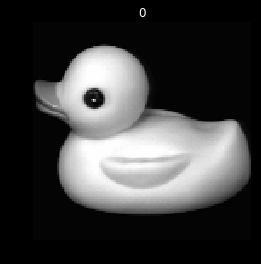

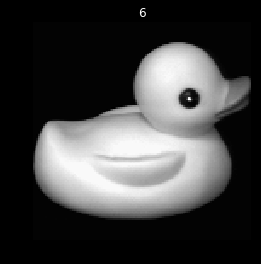

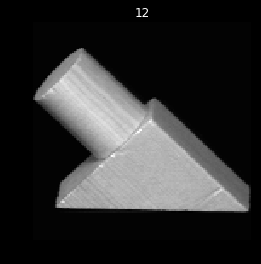

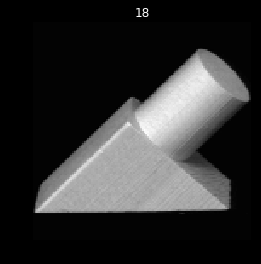

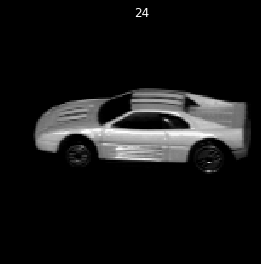

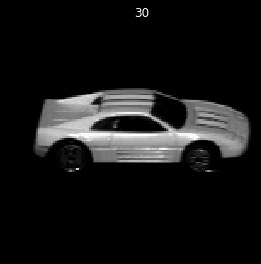

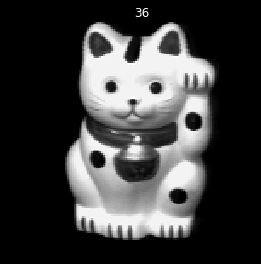

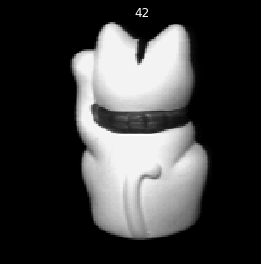

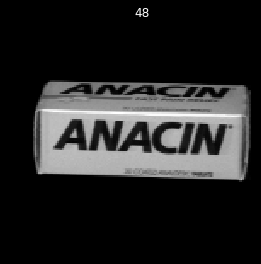

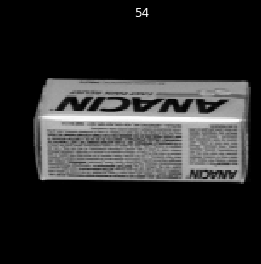

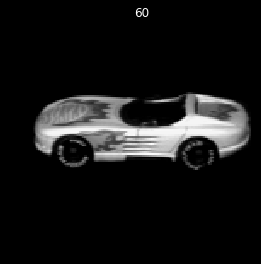

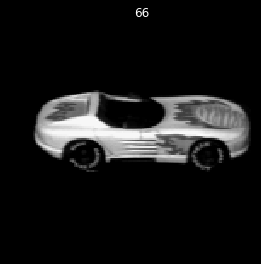

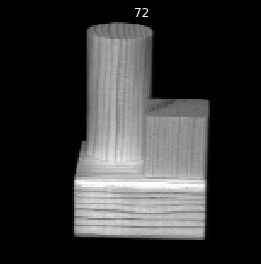

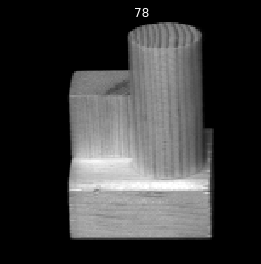

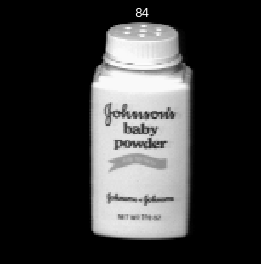

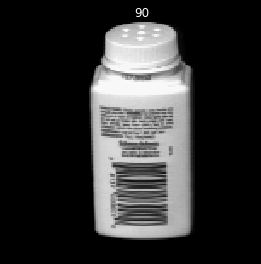

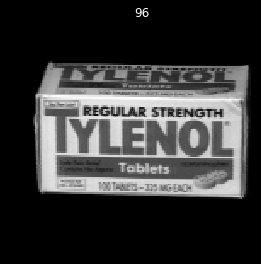

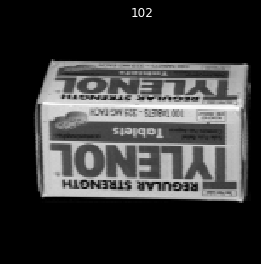

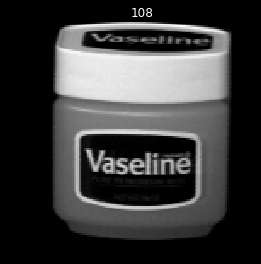

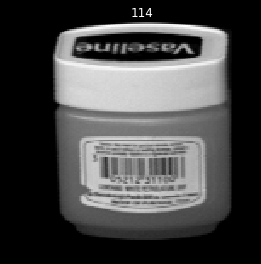

In [5]:
for i in range(0, 120, 6):
  plt.title(i)
  display_image(imgs[i, :], cmap='gray')
  

## PCA 

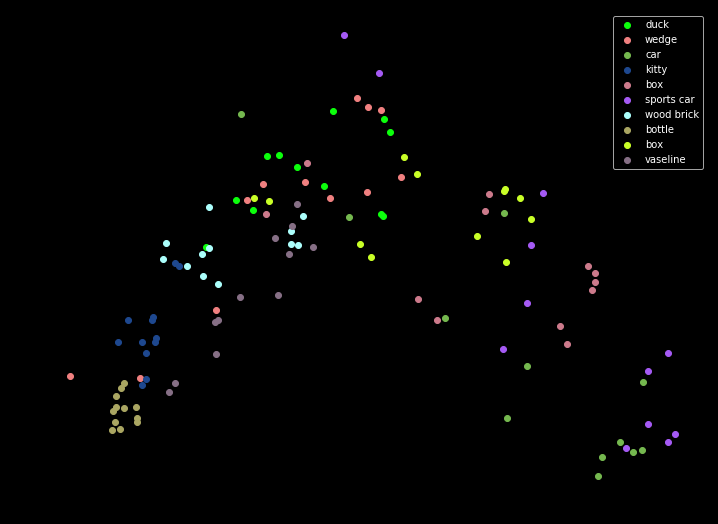

In [6]:
pca = PCA()

imgs_pca = pca.fit_transform(imgs)

rec_error = (np.linalg.norm(
  pca.inverse_transform(imgs_pca) -
  imgs))

plt.figure(figsize=(12,9))
signed_scatterplot(imgs_pca, labels, label_names)
plt.show()

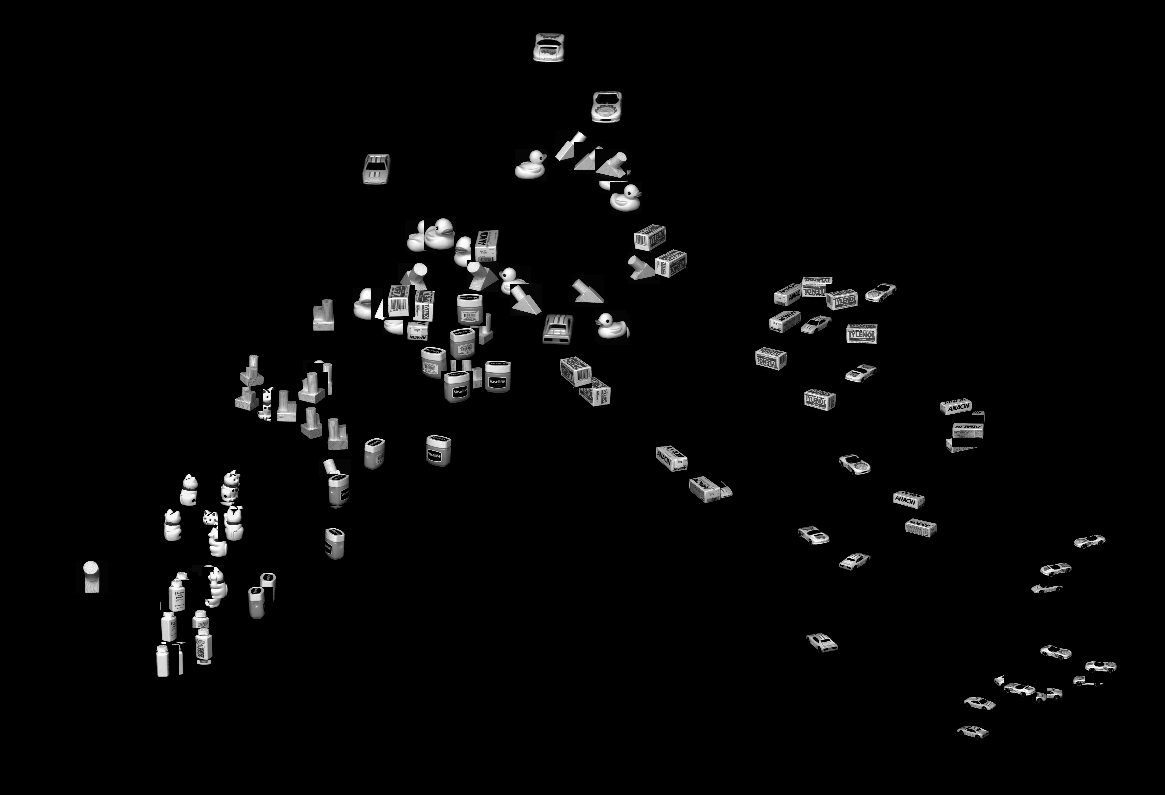

In [7]:
images_scatterplot(imgs, imgs_pca)
plt.show()

In [8]:
# utility to train over a range of parameters

def train_reducers(reducer_class, lo, hi):
  def train_reducers_generator():
    for i in range(lo, hi):
      geom = Geometry(adjacency_kwds=dict(n_neighbors=i))
      reducer = reducer_class(geom=geom).fit(imgs)
      yield i, reducer
  return dict(train_reducers_generator())

def plot_results(reducers):
  ax = plt.figure(figsize=(9,6))
  rng = sorted(list(reducers.keys()))
  errs = [reducers[i][1] for i in rng]
  plt.plot(rng, errs)
  plt.xlabel('n_neighbors')
  plt.ylabel('reconstruction error')
  plt.show()

## Locally Linear Embedding (LLE)

In [9]:
%time lles = train_reducers(\
  LocallyLinearEmbedding,\
  lo=3, hi=15)

CPU times: user 12.7 s, sys: 232 ms, total: 12.9 s
Wall time: 8.76 s


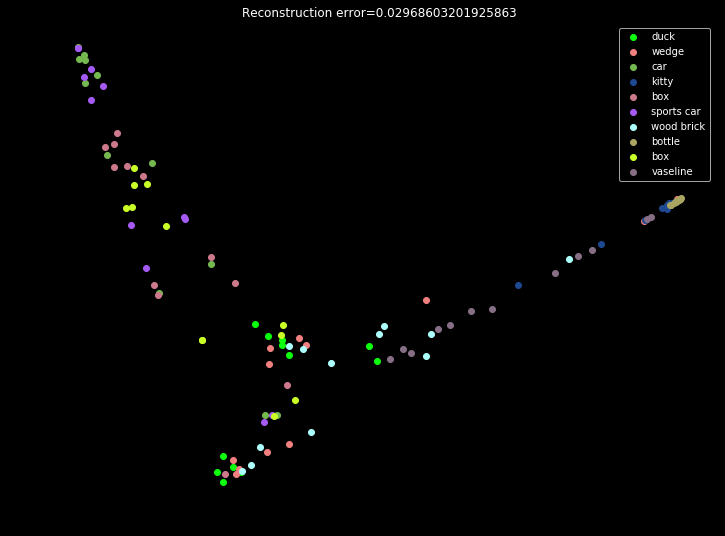

In [10]:
lle = lles[13]
imgs_lle = lle.fit_transform(imgs)

plt.figure(figsize=(12,9))
plt.title('Reconstruction error={}'.format(lle.error_))
signed_scatterplot(imgs_lle, labels, label_names)
plt.show()

## Plot with  edges between adjacent rotated objects

For example embeddings of these two images are joined with edge

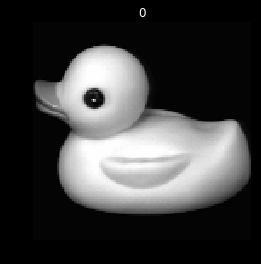

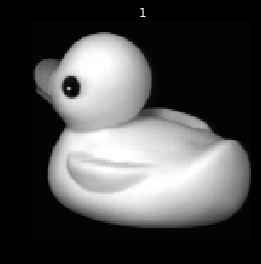

In [11]:
for i in range(0, 2):
  plt.title(i)
  display_image(imgs[i, :], cmap='gray')
  

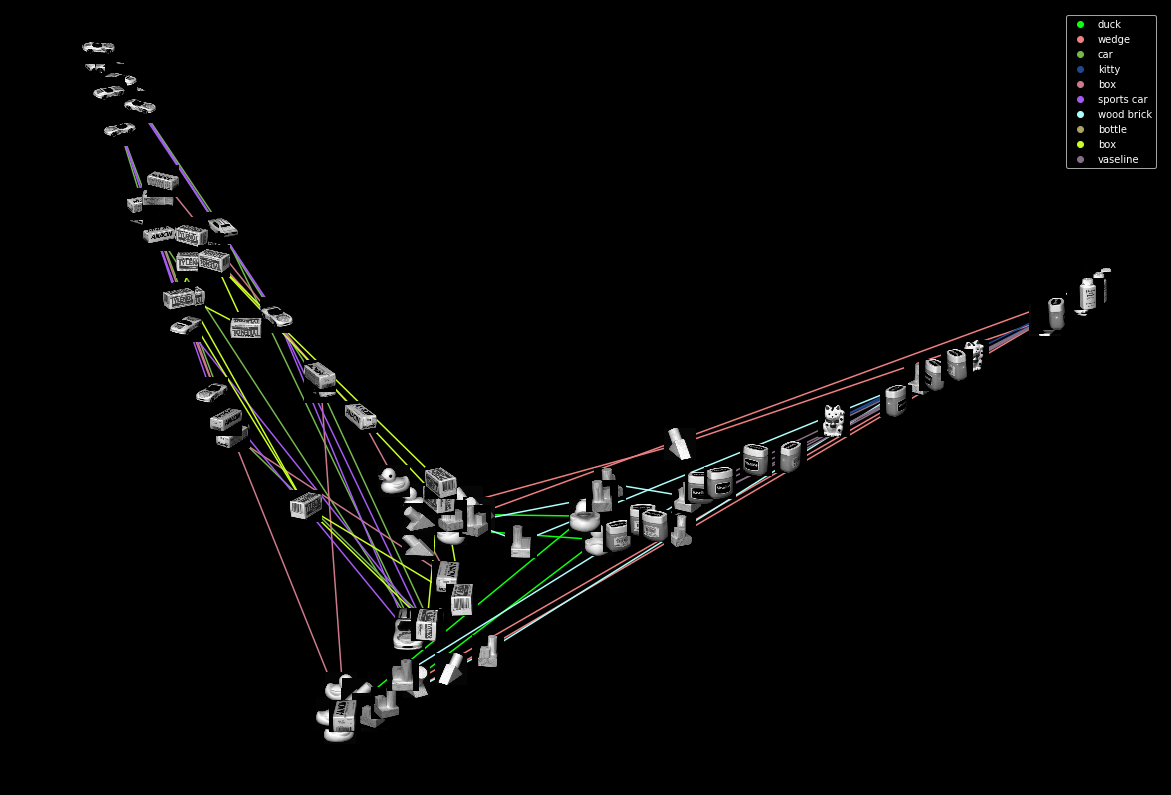

In [12]:
images_scatterplot(imgs, imgs_lle, show_trajectories=True, labels=labels, label_names=label_names)
plt.show()

## Isomap

In [13]:
isomap = Isomap(geom=Geometry(adjacency_kwds=dict(n_neighbors=15)))
imgs_isomap = isomap.fit_transform(imgs)


In [14]:
%time isomaps = dict(train_reducers(Isomap, lo=9, hi=25))

CPU times: user 12.1 s, sys: 172 ms, total: 12.3 s
Wall time: 9.13 s


In [15]:
isomap = isomaps[19]
%time imgs_isomap = isomap.fit_transform(imgs)

CPU times: user 18.1 ms, sys: 45 µs, total: 18.1 ms
Wall time: 9.3 ms


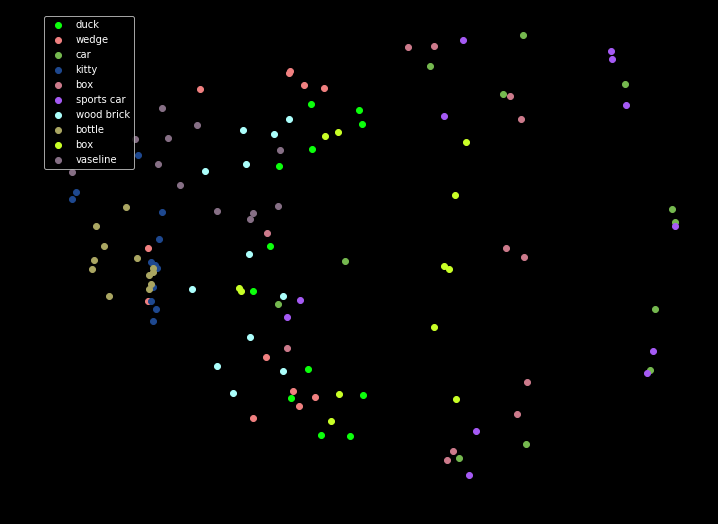

In [16]:
plt.figure(figsize=(12, 9))
#plt.title('Reconstruction error={}'.format(isomap.reconstruction_error()))

signed_scatterplot(imgs_isomap, labels, label_names)
plt.show()

## Plot with  edges between adjacent rotations of objects

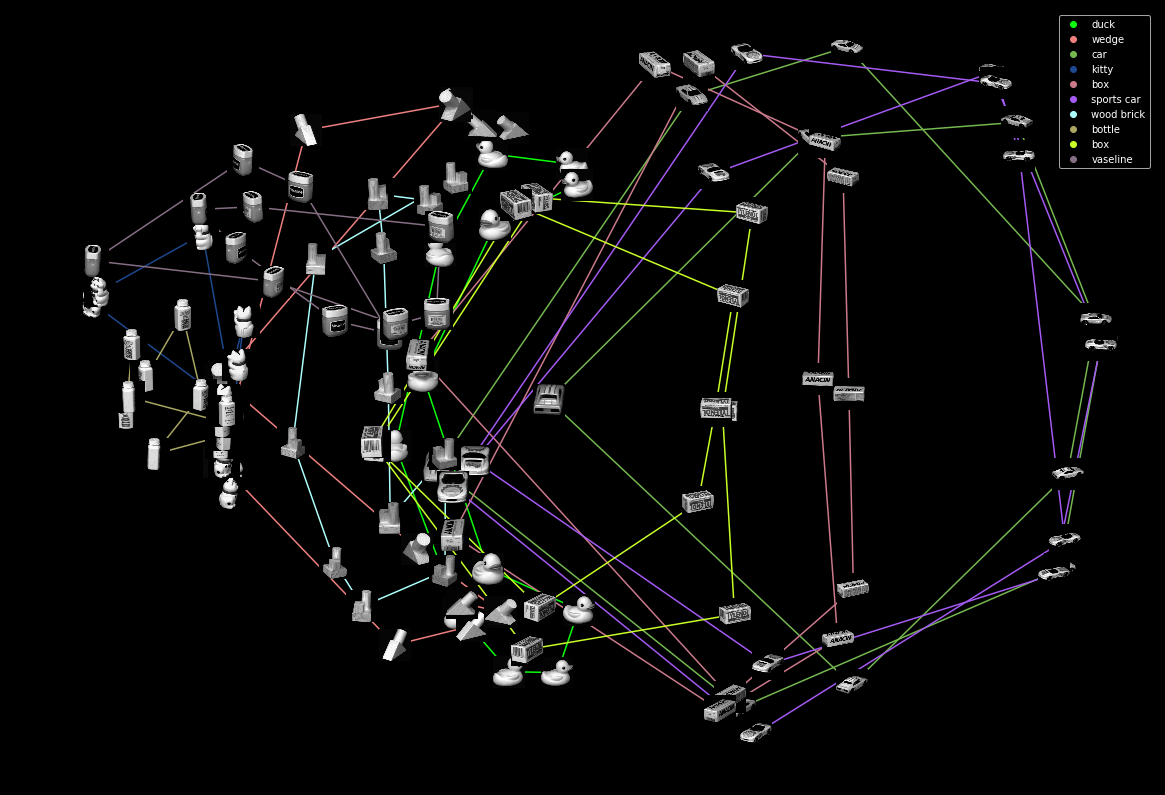

In [17]:
images_scatterplot(imgs, imgs_isomap, True, labels, label_names)
plt.show()

## Local Tangent Space Alignment (LTSA)

In [18]:
from megaman.embedding import LTSA

ltsa = LTSA(radius=0.95)

imgs_ltsa = ltsa.fit_transform(imgs)

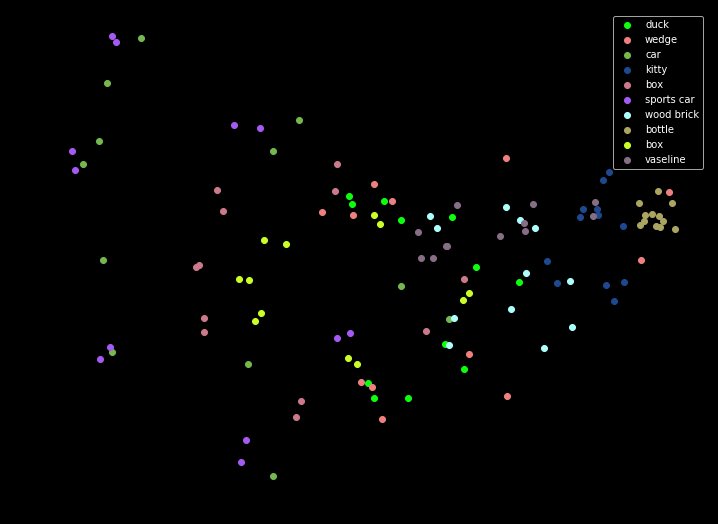

In [19]:
plt.figure(figsize=(12, 9))

signed_scatterplot(imgs_ltsa, labels, label_names)
plt.show()

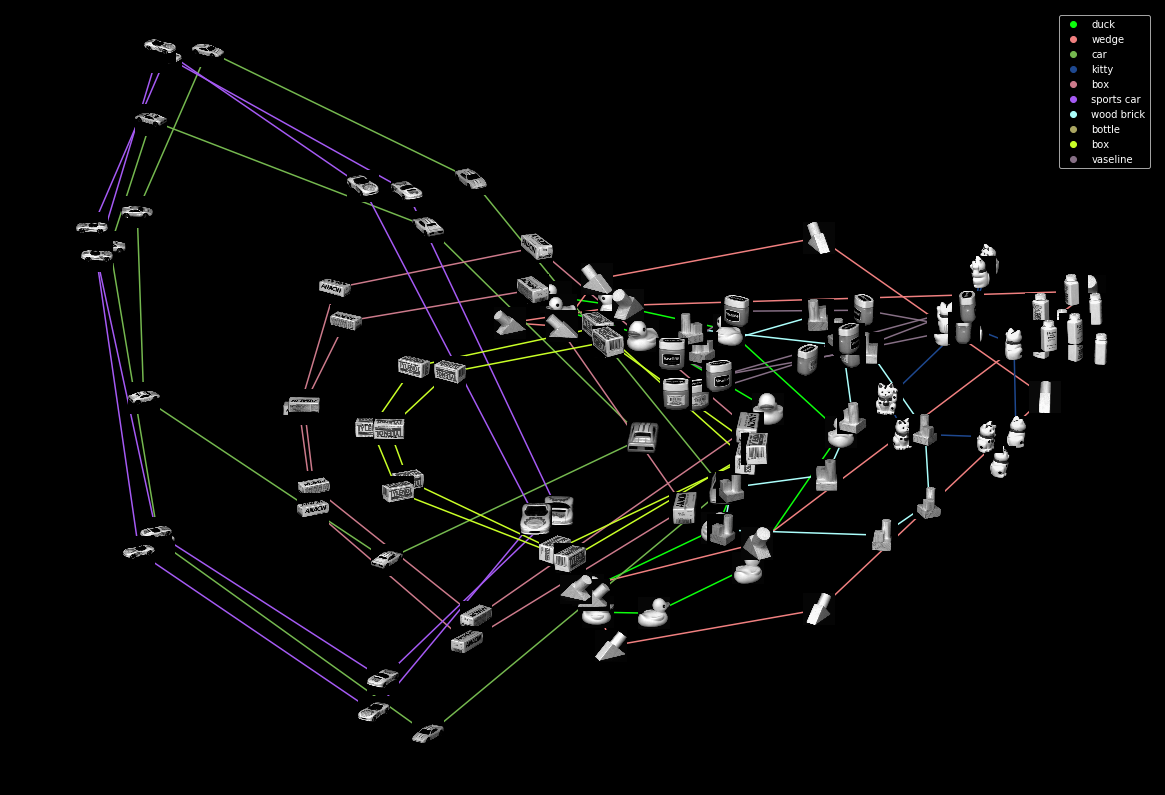

In [20]:
images_scatterplot(imgs, imgs_ltsa, show_trajectories=True, labels=labels, label_names=label_names)
plt.show()

## UMAP (Uniform Manifold Approximation and Projection)

In [21]:
import umap

umapper = umap.UMAP(
  n_neighbors=15,
  min_dist=0.25,
  metric='euclidean'
)

imgs_umap = umapper.fit_transform(imgs)

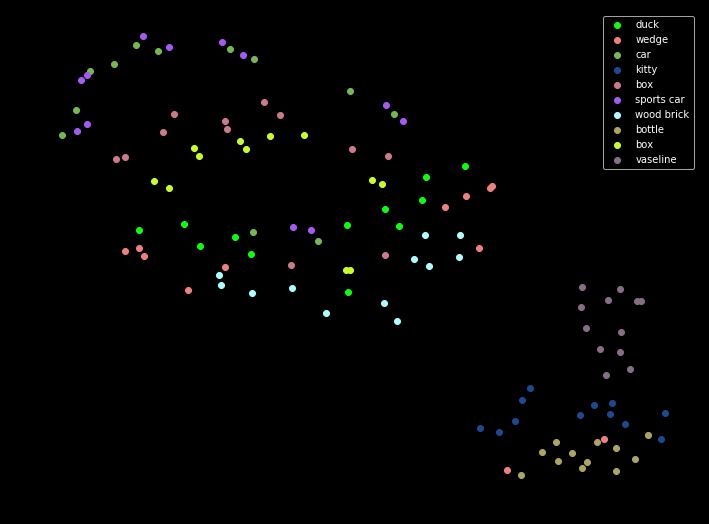

In [22]:
plt.figure(figsize=(12, 9))

signed_scatterplot(imgs_umap, labels, label_names)
plt.show()

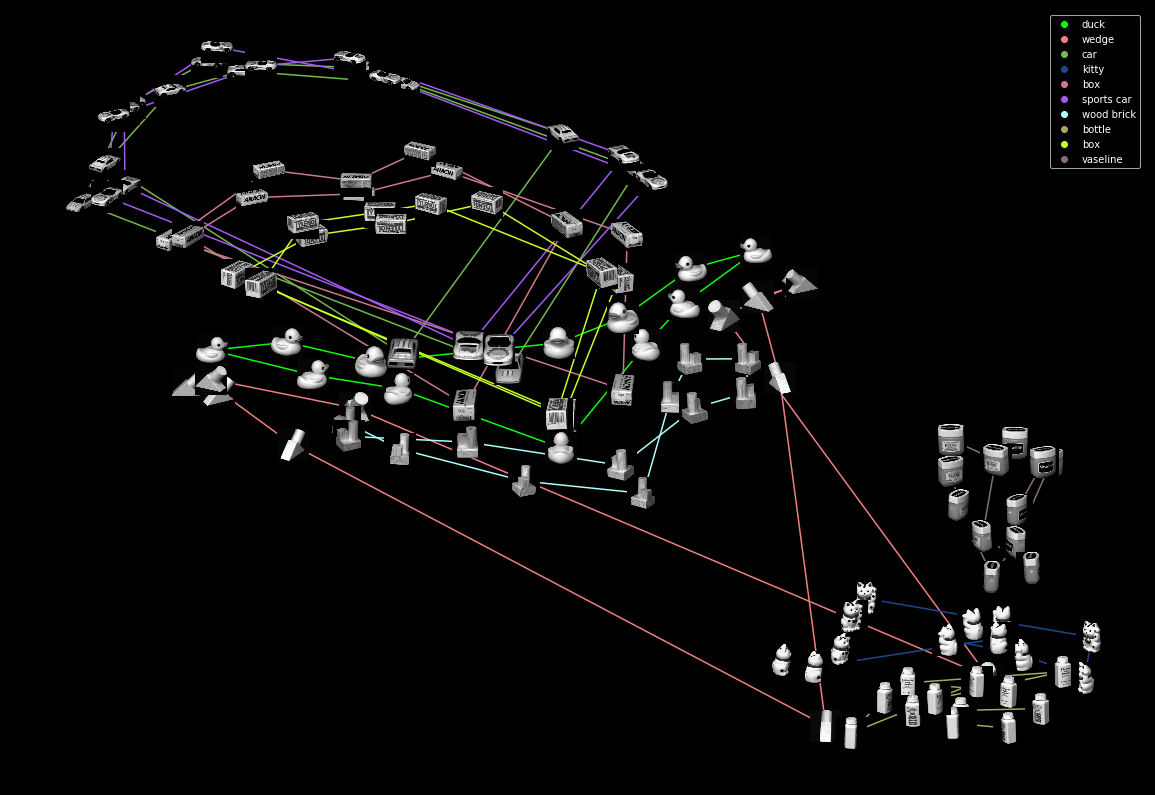

In [23]:
images_scatterplot(imgs, imgs_umap, show_trajectories=True, labels=labels, label_names=label_names)
plt.show()